IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x1264aedd0> (for post_execute), with arguments args (),kwargs {}:


UnboundLocalError: local variable 'fill' referenced before assignment

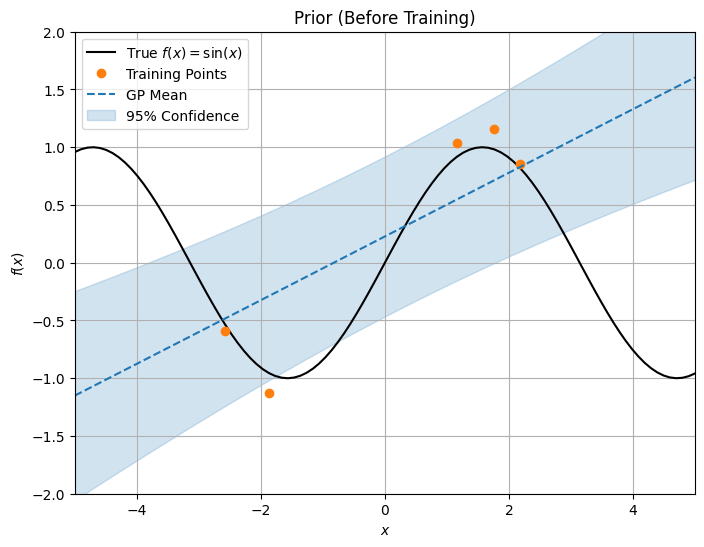

In [3]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set random seed for reproducibility
torch.manual_seed(17)

# --- Data Generation (1D) ---
x = np.linspace(-5, 5, 100)  # 1D input space
true_f = np.sin(x)  # True function: sin(x)
X = x.reshape(-1, 1)  # Shape: (100, 1)

# Training data: 5 random points with noise
train_indices = np.random.choice(len(x), 5, replace=False)
train_x_np = x[train_indices]
train_y_np = true_f[train_indices] + np.random.normal(0, 0.1, size=5)  # Add noise

train_x = torch.from_numpy(train_x_np).float().unsqueeze(-1)  # Shape: (5, 1)
train_y = torch.from_numpy(train_y_np).float()  # Shape: (5,)
X_tensor = torch.from_numpy(X).float()  # Shape: (100, 1)

# --- Define the GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=1)  # 1D, so ard_num_dims=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(train_x, train_y, likelihood)

# --- Set Initial Hyperparameters ---
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0])
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)
model.covar_module.outputscale = 1.0
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)
likelihood.noise = 0.1

# --- Training Setup ---
model.train()
likelihood.train()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Store states for animation
states = []

# Initial state (prior)
model.eval()
likelihood.eval()
with torch.no_grad():
    pred = likelihood(model(X_tensor))
    states.append({
        'mean': pred.mean.numpy(),
        'std': pred.stddev.numpy(),
        'stage': 'Prior (Before Training)'
    })
model.train()
likelihood.train()

# Training loop with intermediate states
max_iterations = 10
for i in range(max_iterations):
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    optimizer.step(closure)
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred = likelihood(model(X_tensor))
        states.append({
            'mean': pred.mean.numpy(),
            'std': pred.stddev.numpy(),
            'stage': f'Training Step {i+1}'
        })
    model.train()
    likelihood.train()

# --- Animation Setup ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_xlim(-5, 5)
ax.set_ylim(-2, 2)
ax.grid(True)

# Plot true function and training points (static)
ax.plot(x, true_f, 'k-', label='True $f(x) = \sin(x)$')
ax.plot(train_x_np, train_y_np, 'C1o', label='Training Points')

# Initial GP plot (mean and uncertainty)
mean_line, = ax.plot(x, states[0]['mean'], 'C0--', label='GP Mean')
fill = ax.fill_between(x, 
                       states[0]['mean'] - 2 * states[0]['std'], 
                       states[0]['mean'] + 2 * states[0]['std'], 
                       color='C0', alpha=0.2, label='95% Confidence')

# Legend
ax.legend(loc='upper left')

# Title for stage
title = ax.set_title(states[0]['stage'])

# --- Animation Function ---
def update(frame):
    # Update mean line
    mean_line.set_ydata(states[frame]['mean'])
    
    # Clear previous fill_between artists
    for artist in ax.collections[:]:  # Copy list to avoid modification issues
        if artist != fill:  # Avoid removing initial fill if still present
            artist.remove()
    
    # Update confidence interval
    fill = ax.fill_between(x, 
                           states[frame]['mean'] - 2 * states[frame]['std'], 
                           states[frame]['mean'] + 2 * states[frame]['std'], 
                           color='C0', alpha=0.2)
    
    # Update title
    title.set_text(states[frame]['stage'])
    
    # Return updated artists
    return [mean_line, fill]

# --- Create and Save Animation ---
ani = FuncAnimation(fig, update, frames=range(len(states)), blit=False, interval=500)
ani.save('gpr_1d_animation.gif', writer='pillow')
plt.show()

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


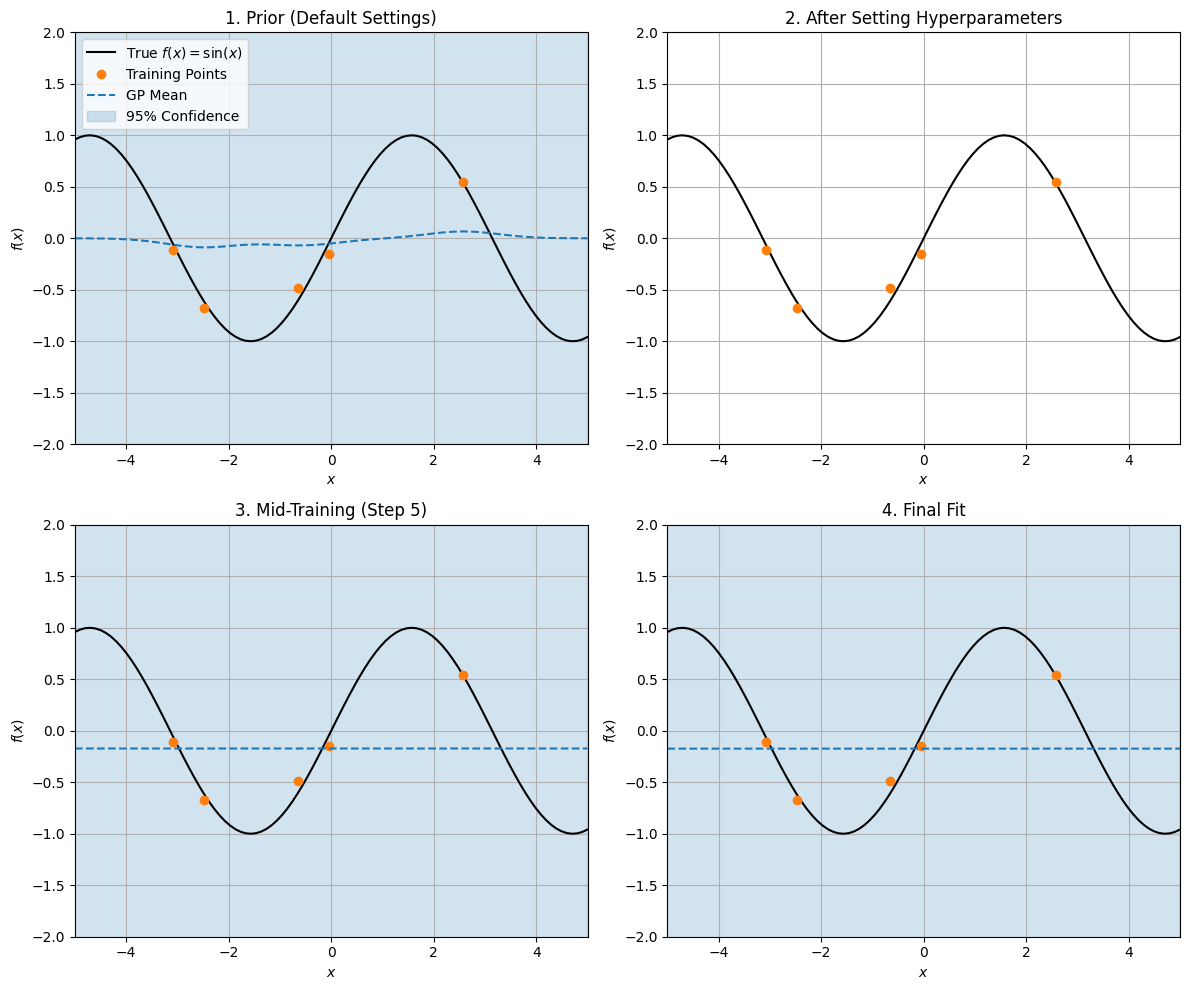

In [4]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(17)

# --- Data Generation (1D) ---
x = np.linspace(-5, 5, 100)  # 1D input space
true_f = np.sin(x)  # True function: sin(x)
X = x.reshape(-1, 1)  # Shape: (100, 1)

# Training data: 5 random points with noise
train_indices = np.random.choice(len(x), 5, replace=False)
train_x_np = x[train_indices]
train_y_np = true_f[train_indices] + np.random.normal(0, 0.1, size=5)  # Add noise

train_x = torch.from_numpy(train_x_np).float().unsqueeze(-1)  # Shape: (5, 1)
train_y = torch.from_numpy(train_y_np).float()  # Shape: (5,)
X_tensor = torch.from_numpy(X).float()  # Shape: (100, 1)

# --- Define the GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=1)  # 1D
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(train_x, train_y, likelihood)

# --- Function to Get Predictions ---
def get_predictions(model, likelihood, X_tensor):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred = likelihood(model(X_tensor))
        return pred.mean.numpy(), pred.stddev.numpy()

# --- Store States for Visualization ---
states = []

# 1. Prior (Before Setting Hyperparameters)
mean, std = get_predictions(model, likelihood, X_tensor)
states.append(('1. Prior (Default Settings)', mean, std))

# --- Set Initial Hyperparameters ---
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0])
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)
model.covar_module.outputscale = 1.0
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)
likelihood.noise = 0.1

# 2. After Setting Hyperparameters
mean, std = get_predictions(model, likelihood, X_tensor)
states.append(('2. After Setting Hyperparameters', mean, std))

# --- Training Setup ---
model.train()
likelihood.train()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss

# 3. Mid-Training (After 5 Steps)
for i in range(5):
    optimizer.step(closure)
mean, std = get_predictions(model, likelihood, X_tensor)
states.append(('3. Mid-Training (Step 5)', mean, std))

# 4. Final Fit (After 10 Total Steps)
for i in range(5):  # Additional 5 steps to reach 10
    optimizer.step(closure)
mean, std = get_predictions(model, likelihood, X_tensor)
states.append(('4. Final Fit', mean, std))

# --- Visualization with Static Plots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Flatten for easy indexing

for i, (title_text, mean, std) in enumerate(states):
    ax = axs[i]
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-2, 2)
    ax.grid(True)
    
    # Plot true function and training points
    ax.plot(x, true_f, 'k-', label='True $f(x) = \sin(x)$')
    ax.plot(train_x_np, train_y_np, 'C1o', label='Training Points')
    
    # Plot GP mean and uncertainty
    ax.plot(x, mean, 'C0--', label='GP Mean')
    ax.fill_between(x, mean - 2 * std, mean + 2 * std, color='C0', alpha=0.2, label='95% Confidence')
    
    # Title and legend
    ax.set_title(title_text)
    if i == 0:  # Add legend only to the first plot to avoid clutter
        ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('gpr_1d_static_visualization.png')
plt.show()

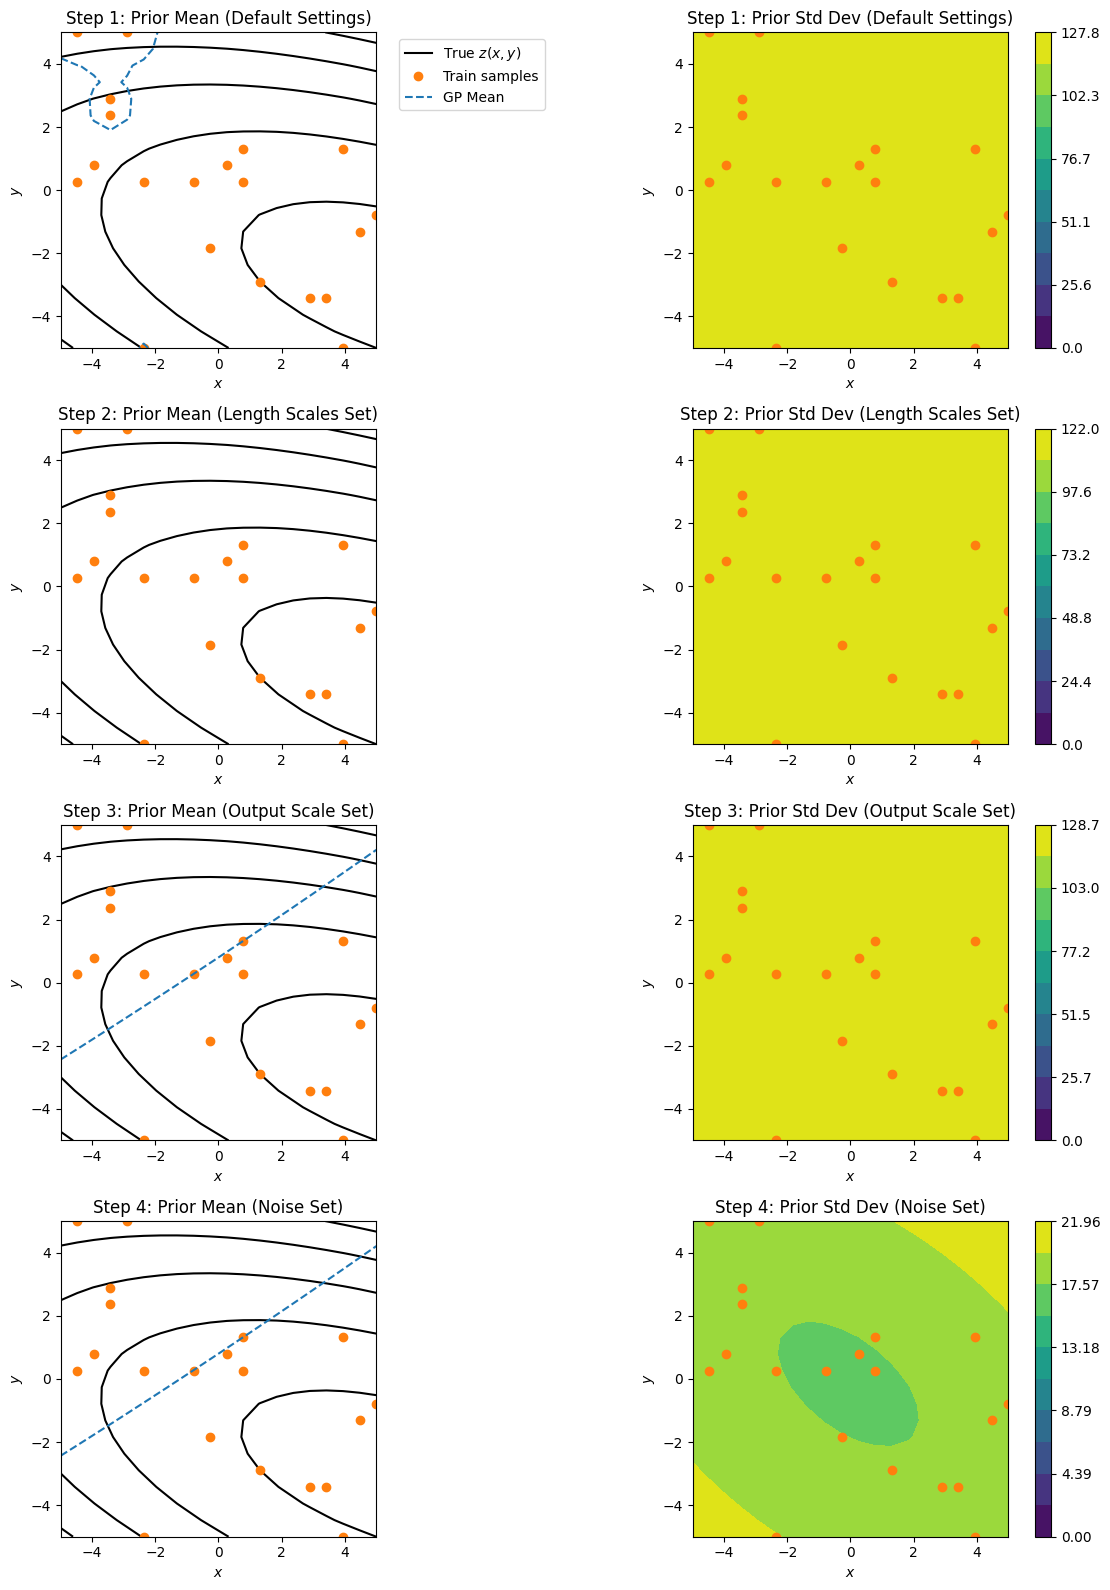

In [5]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(17)

# --- Data Generation (2D) ---
nv = 20
xv = np.linspace(-5., 5., nv)
yv = np.linspace(-5., 5., nv)
x, y = np.meshgrid(xv, yv)
z = (x - 3.)**2 + 2.*x*y + (2.*y + 3.)**2 - 3.
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1, 1)

# --- Data Splitting and Normalization ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)
y_mean = Y_train.mean()
y_std = Y_train.std()
Y_train_normalized = (Y_train - y_mean) / y_std

train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(Y_train_normalized).float().squeeze()
X_tensor = torch.from_numpy(X).float()

# --- Define the GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# --- Function to Get Predictions ---
def get_predictions(model, likelihood, X_tensor, y_mean, y_std):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred = likelihood(model(X_tensor))
        mean = pred.mean.numpy() * y_std + y_mean  # Scale back to original space
        std = pred.stddev.numpy() * y_std
    return mean.reshape(nv, nv), std.reshape(nv, nv)

# --- Visualization Steps ---
fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Step 1: Initial Model with Default Settings
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(train_x, train_y, likelihood)
mean, std = get_predictions(model, likelihood, X_tensor, y_mean, y_std)

# Plot Mean
ax = axs[0, 0]
ax.contour(x, y, z, levels=np.linspace(0, 250, 6), colors='k')
ax.plot(*X_train.T, 'C1o')
ax.contour(x, y, mean, levels=np.linspace(0, 250, 6), colors='C0', linestyles='dashed')
ax.set_title('Step 1: Prior Mean (Default Settings)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Plot Std
ax = axs[0, 1]
ax.plot(*X_train.T, 'C1o')
ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11))
plt.colorbar(ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11)), ax=ax)
ax.set_title('Step 1: Prior Std Dev (Default Settings)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Step 2: Set Length Scales
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)
mean, std = get_predictions(model, likelihood, X_tensor, y_mean, y_std)

# Plot Mean
ax = axs[1, 0]
ax.contour(x, y, z, levels=np.linspace(0, 250, 6), colors='k')
ax.plot(*X_train.T, 'C1o')
ax.contour(x, y, mean, levels=np.linspace(0, 250, 6), colors='C0', linestyles='dashed')
ax.set_title('Step 2: Prior Mean (Length Scales Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Plot Std
ax = axs[1, 1]
ax.plot(*X_train.T, 'C1o')
ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11))
plt.colorbar(ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11)), ax=ax)
ax.set_title('Step 2: Prior Std Dev (Length Scales Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Step 3: Set Output Scale
model.covar_module.outputscale = 1.0
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)
mean, std = get_predictions(model, likelihood, X_tensor, y_mean, y_std)

# Plot Mean
ax = axs[2, 0]
ax.contour(x, y, z, levels=np.linspace(0, 250, 6), colors='k')
ax.plot(*X_train.T, 'C1o')
ax.contour(x, y, mean, levels=np.linspace(0, 250, 6), colors='C0', linestyles='dashed')
ax.set_title('Step 3: Prior Mean (Output Scale Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Plot Std
ax = axs[2, 1]
ax.plot(*X_train.T, 'C1o')
ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11))
plt.colorbar(ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11)), ax=ax)
ax.set_title('Step 3: Prior Std Dev (Output Scale Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Step 4: Set Noise
likelihood.noise = 0.1
mean, std = get_predictions(model, likelihood, X_tensor, y_mean, y_std)

# Plot Mean
ax = axs[3, 0]
ax.contour(x, y, z, levels=np.linspace(0, 250, 6), colors='k')
ax.plot(*X_train.T, 'C1o')
ax.contour(x, y, mean, levels=np.linspace(0, 250, 6), colors='C0', linestyles='dashed')
ax.set_title('Step 4: Prior Mean (Noise Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Plot Std
ax = axs[3, 1]
ax.plot(*X_train.T, 'C1o')
ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11))
plt.colorbar(ax.contourf(x, y, std, levels=np.linspace(0, std.max(), 11)), ax=ax)
ax.set_title('Step 4: Prior Std Dev (Noise Set)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.grid(False)

# Add legend to the first mean plot
truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker='o', linestyle='none', label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle='--', label='GP Mean')
axs[0, 0].legend(handles=[truth_line, sample_line, mean_line], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('gpr_2d_model_definition_steps.png')
plt.show()